<a href="https://colab.research.google.com/github/yongtaoliu/dual-GP/blob/main/DualGP_Manuscript_Notebook_Noise_SSIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dual GP

*  Dual GP developed by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) using GP in GPax
*  Update May 20, 2024

# Install and Import

In [49]:
!pip install gpax

In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

import gpax
import numpyro
import jax.random as jra
import jax.numpy as jnp
gpax.utils.enable_x64()
from sklearn.metrics import mean_squared_error

In [51]:
import matplotlib as mpl
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 150

# Define test model data for optimization

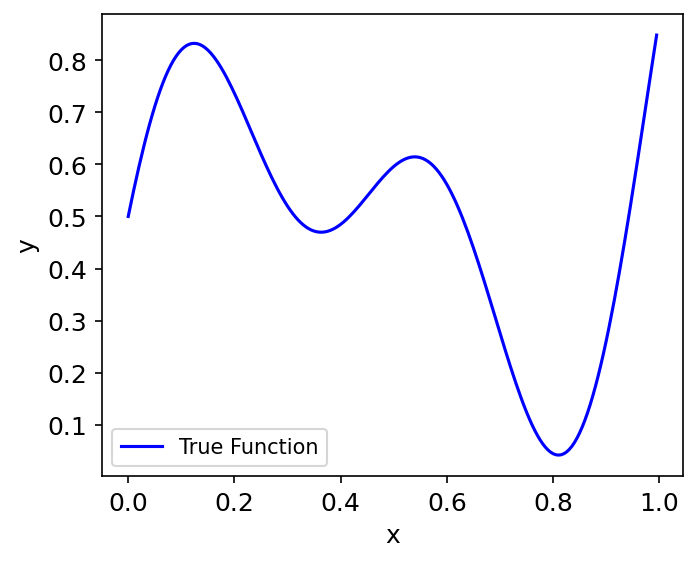

In [52]:
# objective function
def objective(x, a, b, c):
 return (a + b*x) * np.sin(10*x) + c

np.random.seed(3)

# sample x uniformly
N = 200; i_min = 0; i_max = 1  #inputs number, minimum, and maximum
input_x = np.arange(i_min, i_max, (i_max-i_min)/N)
# compute y without noise
A = 0.5; B = -1.2; C = 0.5
output_y = objective(input_x, A, B, C)
# plot model data
plt.figure(figsize = (5, 4))
plt.plot(input_x, output_y, label = "True Function", color = "b")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Define a function to synthsize raw peak data

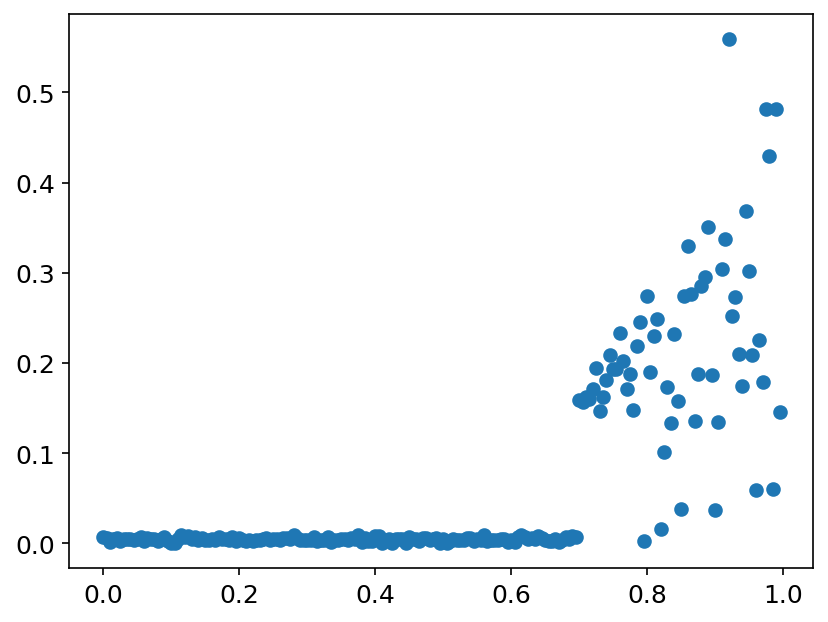

In [53]:
# make a function to synthesize 1D gaussian peak
def make_gaussian_peak(x, amp, mu=0.5, sigma=0.05, noise_sigma = 0.001):
  """
  Gaussian peak function.

  Returns:
    Gaussian peak values.
  """
  gaussian_peak = amp*np.exp(-(x - mu)**2 / (2 * sigma**2))
  noise = np.random.normal(0, noise_sigma, size=x.shape)
  return gaussian_peak + noise

def noise_function(N, r):
  """
  N: number of data points
  r: ratio of data points with low noise, the noise increases gradiently after this ratio threshold
  """
  n1 = np.random.normal(0.002, 0.002, size = int(N*r))
  n2 = []
  for i in range(int(N*(1-r))):
    n2.append(np.random.normal(i*0.1/int(N*(1-r)), i*(0.2/int(N*(1-r)))))
   # n2.append(np.random.normal(0.05, i*(0.1/int(N*(1-r)))))
  n2 = np.asarray(n2).reshape(-1)
  n2 = n2-n2.min()
  n = np.concatenate((n1, n2))
  return n

np.random.seed(10)
spec_noise = noise_function(N, 0.7)
spec_noise = spec_noise - spec_noise.min()

plt.scatter(input_x, spec_noise)
plt.show()

Synthesize raw peak data

In [54]:
x_spec = np.linspace(0, 1, 100)
spec_peaks = np.zeros((N, len(x_spec)))
np.random.seed(10)
distort_points = np.zeros((N))
def norm_ (z):
  return (z - np.min(z)) / (np.max(z) - np.min(z))
y_amp = output_y

for xi in range (N):
    spec_peaks[xi, :] = make_gaussian_peak(x_spec, y_amp[xi], noise_sigma = spec_noise[xi])

syn_spec = spec_peaks

<Figure size 1500x600 with 0 Axes>

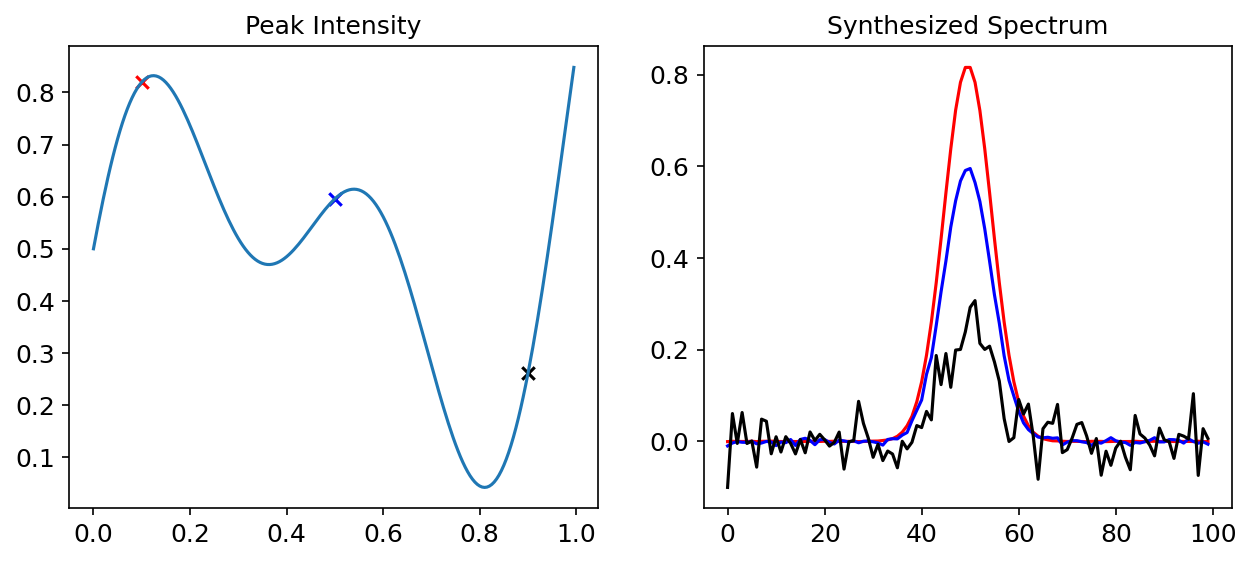

In [55]:
plot1_idx = 20; plot2_idx = 100; plot3_idx = 180
plt.figure(figsize = (10, 4))
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
ax1.plot(input_x, y_amp)
ax1.scatter (input_x[plot1_idx], y_amp[plot1_idx], marker = 'x', color = 'r')
ax1.scatter (input_x[plot2_idx], y_amp[plot2_idx], marker = 'x', color = 'blue')
ax1.scatter (input_x[plot3_idx], y_amp[plot3_idx], marker = 'x', color = 'black')
ax1.set_title('Peak Intensity')
ax2.plot(syn_spec[plot1_idx], color = 'r')
ax2.plot(syn_spec[plot2_idx], color = 'blue')
ax2.plot(syn_spec[plot3_idx], color = 'black')
ax2.set_title('Synthesized Spectrum')

plt.show()

Calculate SSIM of good data and noisy data

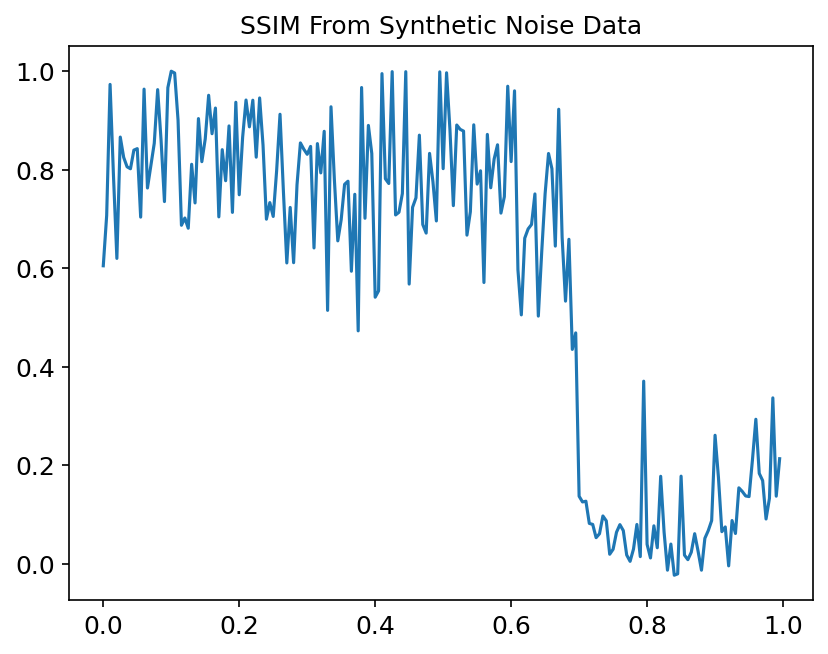

In [56]:
from skimage.metrics import structural_similarity as ssim
ref_spec = syn_spec[plot1_idx]
spec_ssim = np.zeros(N)

def cal_ssim(ref_spec, req_spec):
  ss = ssim(norm_(ref_spec), norm_(req_spec), win_size = 15)
  return ss

for i in range (N):
  req_spec = syn_spec[i]
  ss = cal_ssim(ref_spec, req_spec)
  spec_ssim[i] = ss

spec_ssim = np.asarray(spec_ssim)
plt.figure()
plt.plot(input_x, spec_ssim)
plt.title("SSIM From Synthetic Noise Data")
plt.show()


Compare scalarizer from raw peak data and the true function

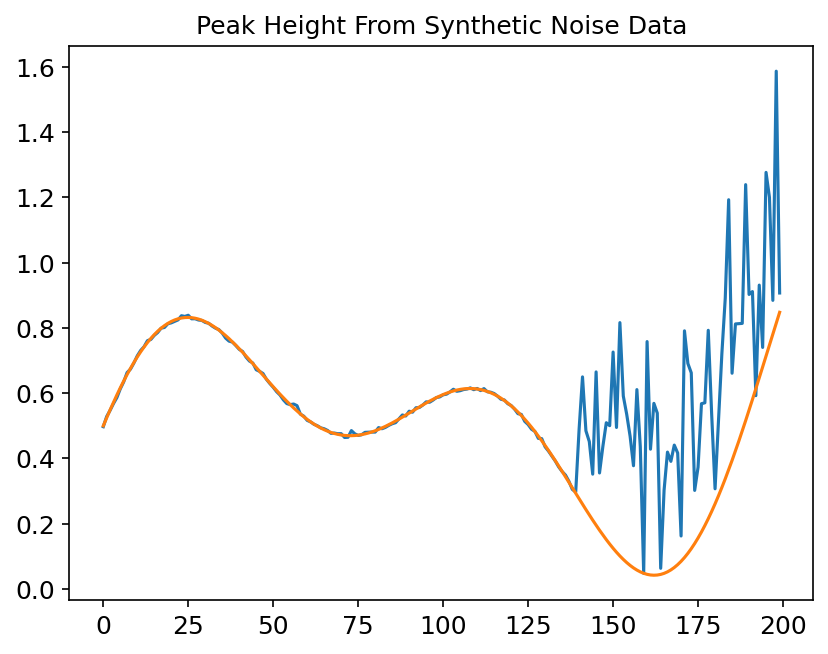

In [57]:
from scipy.signal import find_peaks

# Define a function to extract peak height
def peak_height(spec_):
  peaks, properties = find_peaks(spec_, height=0.01)
  pk_height = properties['peak_heights'].max()
  return pk_height

peak_heights = np.zeros(N)
for xi in range (N):
    peak_heights[xi] = peak_height(syn_spec[xi])

plt.figure()
plt.plot(peak_heights)
plt.plot(y_amp)
plt.title("Peak Height From Synthetic Noise Data")
plt.show()

# Help functions

In [58]:
# Help function for initilizing training
def init_training_data_exp(X, Y, num_seed_points=2, rng_seed=42, list_of_indices=None):
    np.random.seed(rng_seed)
    indices = jnp.arange(len(X))
    idx = list_of_indices
    if idx is not None:
        idx = np.array(idx)
    else:
        idx = np.random.randint(0, len(X), num_seed_points)
    idx = np.unique(idx)
    X_train, y_train = X[idx], Y[idx]
    indices_train = indices[idx]
    X_test = jnp.delete(X, idx)
    y_test = jnp.delete(Y, idx, 0)
    indices_test = jnp.delete(indices, idx)
    return X_train, y_train, X_test, y_test, indices_train, indices_test

# Help function for updating train/test data
def update_data(next_point_idx, X_train, X_test, y_train,
                y_train_spec, y_test_spec, indices_train, indices_test):
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train_spec = jnp.append(y_train_spec, y_test_spec[next_point_idx][None], 0)
    y_train = jnp.append(y_train, scalarizer_function(y_test_spec[next_point_idx][None]))
    y_test_spec = jnp.delete(y_test_spec, next_point_idx, 0)
    indices_train = jnp.append(indices_train, indices_test[next_point_idx])
    indices_test = jnp.delete(indices_test, next_point_idx)
    return X_train, X_test, y_train, y_train_spec, y_test_spec, indices_train, indices_test

def scalarizer_function (all_spec):
  """
  scalarizer funciton is to extract peak height from the spec
  """
  spec_scal = []
  for i in range (len(all_spec)):
    spec_scal.append(peak_height(all_spec[i]))
  return np.asarray(spec_scal)

# GP function

In [59]:
# Function for performing a GP step, here we use structure GP (sGP)
def run_GP (xtrain, ytrain, xtest, fn = None, fn_priors = None):
  rng_key, rng_key_predict = gpax.utils.get_keys(1)
  # Obtain/update GP posterior
  gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=fn, mean_fn_prior=fn_priors)
  gp_model.fit(rng_key, xtrain, ytrain)
  # Compute acquisition function
  obj = gpax.acquisition.UE(rng_key_predict, gp_model, X_test)
  # Get GP prediction
  posterior_mean, f_samples = gp_model.predict(rng_key_predict, xtest, n = 200)
  return gp_model, obj, posterior_mean, f_samples

# Functions for sGP mean function and priors
from typing import Dict
# structure mean function
def custom_structure(x, params):
    """Custom structure function"""
    return (params["a"] + params["b"] * x) * jnp.sin(10*x) + params["c"]

# Priors over the mean function
def custom_structure_priors():
    """Priors over linear coefficients"""
    a = numpyro.sample("a", numpyro.distributions.Normal(0, 1))
    b = numpyro.sample("b", numpyro.distributions.Normal(0, 1))
    c = numpyro.sample("c", numpyro.distributions.Normal(0, 1))
    return {"a": a, "b": b, "c": c}

# Perform single GP exploration

### Initialize training data

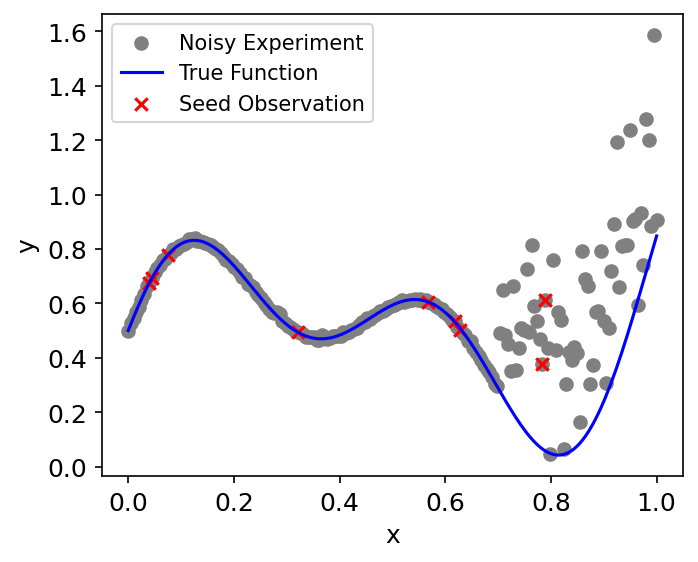

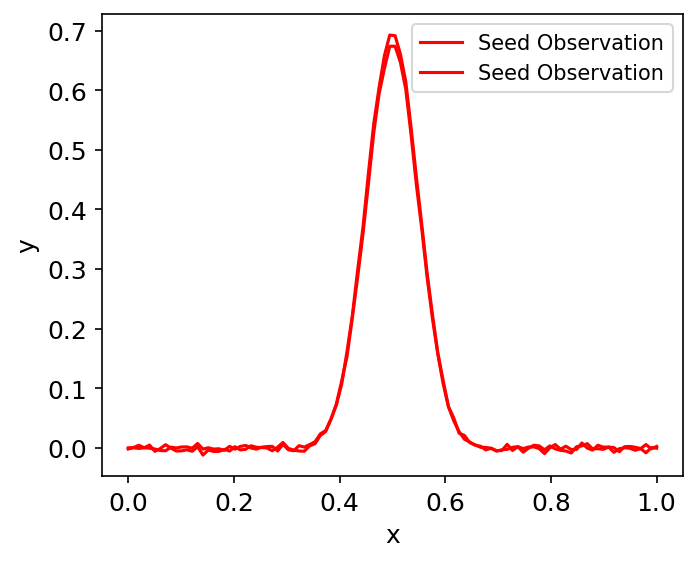

In [60]:
# Select random initial points
init_points = 10 # number of initial points

# Full dataset
X = jnp.asarray(input_x)
X = norm_(X)
Y_spec = syn_spec

# initialize training data
(X_train, y_train_spec, X_test, y_test_spec,
 indices_train, indices_test) = init_training_data_exp(X, Y_spec, num_seed_points=init_points, rng_seed=10)

y_train = scalarizer_function(y_train_spec)
# Plot initial trian dataset
plt.figure(figsize = (5, 4))
plt.scatter(X, peak_heights, label = "Noisy Experiment", color = "Gray")
plt.plot(X, y_amp, label = "True Function", color = "blue")
plt.scatter(X_train, y_train, label = "Seed Observation", color = 'red', marker = 'x')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

plt.figure(figsize = (5, 4))
plt.plot(x_spec, y_train_spec[0], label = "Seed Observation", color = 'red')
plt.plot(x_spec, y_train_spec[1], label = "Seed Observation", color = 'red')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [61]:
# Copy seed points
X_seed = X_train.copy(); y_seed = y_train.copy()

### Start single GP exploration


Exploration step 1


sample: 100%|██████████| 4000/4000 [00:05<00:00, 789.99it/s, 15 steps of size 2.73e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.20      0.42      0.22     -0.50      0.87   1296.10      1.00
          b     -0.30      0.59     -0.34     -1.21      0.71   1312.44      1.00
          c      0.35      0.62      0.37     -0.66      1.35   1540.64      1.00
k_length[0]      2.45      2.65      1.70      0.13      5.00   1089.95      1.00
    k_scale      0.94      1.03      0.64      0.03      2.05   1307.72      1.00
      noise      0.11      0.12      0.08      0.01      0.23   1027.26      1.00



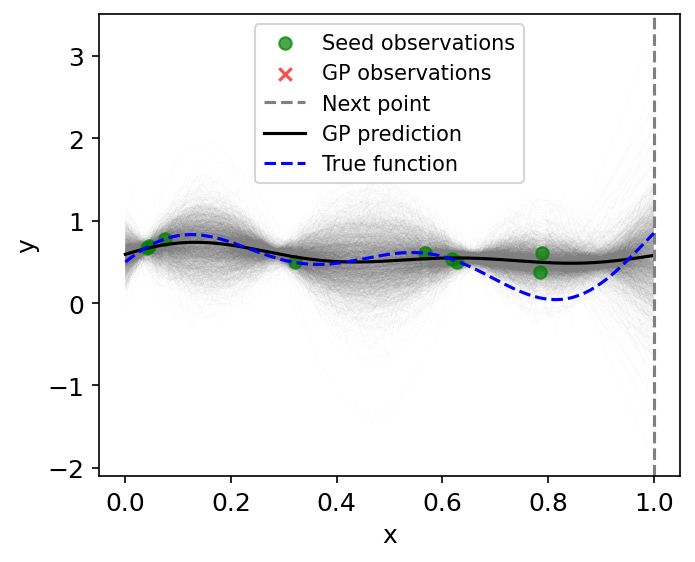


Exploration step 2


sample: 100%|██████████| 4000/4000 [00:04<00:00, 842.05it/s, 31 steps of size 1.97e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.25      0.38      0.28     -0.32      0.90    877.25      1.00
          b     -0.50      0.50     -0.53     -1.23      0.36    894.33      1.00
          c      0.39      0.64      0.43     -0.62      1.46   1114.94      1.00
k_length[0]      2.85      2.87      1.99      0.07      5.87   1102.74      1.00
    k_scale      0.95      1.20      0.61      0.03      2.02   1165.24      1.00
      noise      0.09      0.09      0.07      0.01      0.19    958.09      1.00



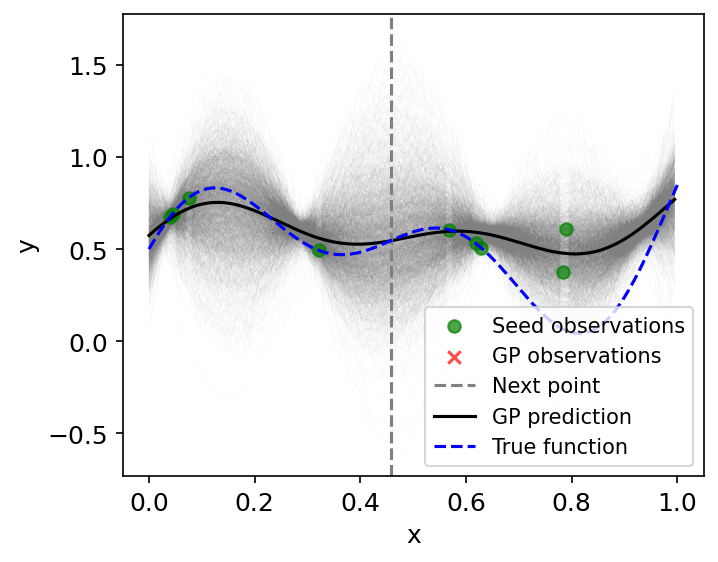


Exploration step 3


sample: 100%|██████████| 4000/4000 [00:05<00:00, 751.92it/s, 15 steps of size 2.87e-01. acc. prob=0.79]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      0.27      0.30      0.29     -0.21      0.77   1054.38      1.00
          b     -0.52      0.44     -0.56     -1.25      0.18   1067.42      1.00
          c      0.43      0.62      0.45     -0.57      1.43   1008.92      1.00
k_length[0]      2.85      2.68      2.09      0.19      5.69   1194.91      1.00
    k_scale      0.92      1.09      0.60      0.04      1.97   1181.10      1.00
      noise      0.07      0.07      0.05      0.01      0.14    978.03      1.00



In [ ]:
rng_key, rng_key_predict = gpax.utils.get_keys(1)
exploration_steps = 50

for i in range(exploration_steps):
    print("\nExploration step {}".format(i+1))
    # Execute GP
    gpbo, obj, posterior_mean, f_samples = run_GP(X_train, y_train, X_test,
                                            fn = custom_structure, fn_priors = custom_structure_priors)
    # Next point
    # get the next point to measure
    next_point_idx = obj.argmax()
    next_point = X_test[next_point_idx]
    y_next = y_test_spec[next_point_idx]

    # Plot results-------------------------
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.scatter(X_seed, y_seed, marker='o', c='g', zorder=1, label="Seed observations", alpha=0.7)
    ax.scatter(X_train[init_points:], y_train[init_points:], marker='x', c='r', zorder=1, label="GP observations", alpha=0.7)
    ax.axvline(next_point, linestyle = "--", c = "Gray", label="Next point")
    for y1 in f_samples:
      ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='Gray', alpha=.1)
    l, = ax.plot(X_test, f_samples[0].mean(0), lw=1, c='Gray', alpha=1)
    ax.plot(X_test, posterior_mean, lw=1.5, zorder=1, c='black', label='GP prediction')
    ax.plot(X, y_amp, c='blue', linestyle='--', label='True function')
    ax.legend();
    l.set_alpha(0)
    plt.show()
    #------------------------------------------#

    # Get mean function parameters
    fn_params = gpbo.get_samples()
    fn_a, fn_b, fn_c = fn_params['a'], fn_params['b'], fn_params['c']

    # Save results for post analysis
    np.savez("singleGP_step{}.npz".format(i), next_point_idx = next_point_idx, obj = obj,
             posterior_mean = posterior_mean, f_samples = f_samples, X_train = X_train, X_test = X_test,
             y_train = y_train, y_train_spec = y_train_spec, y_test_spec = y_test_spec,
             indices_train = indices_train, indices_test = indices_test, fn_a = fn_a, fn_b = fn_b, fn_c = fn_c)

    # Update Train and Test datasets
    (X_train, X_test, y_train, y_train_spec, y_test_spec,
     indices_train, indices_test) = update_data(next_point_idx, X_train, X_test, y_train,
                                                y_train_spec, y_test_spec, indices_train, indices_test)

# Perform Dual GP exploration

### The 2nd GP function

In [ ]:
def second_GP(xtrain, ysecond, Xall):
  rng_key, rng_key_predict = gpax.utils.get_keys(2)
  # Obtain/update GP posterior
  gp_model = gpax.ExactGP(1, kernel='Matern')
  gp_model.fit(rng_key, xtrain, ysecond)
  # Get GP prediction
  posterior_mean, _ = gp_model.predict(rng_key_predict, Xall)
  return posterior_mean

### Intervention function for using the 2nd GP result to adjust the acquisition of the main GPBO

In [ ]:
def interven (filter_score, acq, X_train, y_train, y_train_spec,
              indices_train, indices_test, interven_percent=0.3):
  # Determine space, where the noise is above interven_percent level, to remove
  idx_for_filterout = np.where(filter_score < np.quantile(filter_score, interven_percent))[0]
  # Check if points in train set are from this space
  try:
    train_filterout_idx = np.where(np.isin(indices_train, idx_for_filterout))[0]
  except:
    train_filterout_idx = None
  # Remove points from train set
  if train_filterout_idx is not None:
    X_train_update = np.delete(X_train, train_filterout_idx, 0)
    y_train_update = np.delete(y_train, train_filterout_idx, 0)
    y_train_spec_update = np.delete(y_train_spec, train_filterout_idx, 0)
    indices_train_update = np.delete(indices_train, train_filterout_idx, 0)

  # Adjust acquisiton
  acq_idx_filterout = np.where(np.isin(indices_test, idx_for_filterout))[0]
  # 1st adjusting method
  adjust_acq_1 = acq.at[acq_idx_filterout].set(obj.min()) # set acq at removal space to 0
  # 2nd adjusting method
  score_testset = filter_score[indices_test]
  adjust_acq_2 = (acq*score_testset).at[acq_idx_filterout].set(obj.min()) # tune acq with noise, then set tuned acq at removal space to 0

  return adjust_acq_1, adjust_acq_2, X_train_update, y_train_update, y_train_spec_update, indices_train_update

Define function for 2nd GP training and update training set based on 2nd GP

In [ ]:
import time
# initialize filter training data
def initialize_filter_data(X_train, y_train_spec, indices_train):
  X_train_filter = X_train
  indices_train_filter = indices_train
  y_train_filter = []
  for ifd in range (len(y_train_spec)):
    score = cal_ssim(ref_spec, y_train_spec[ifd])
    y_train_filter.append(score)
  return X_train_filter, np.asarray(y_train_filter), indices_train_filter

def update_filter_data(intervation_interval, step_num):
  step_record = np.load("DualGP_step{}.npz".format(step_num))
  X_train, indices_train = step_record['X_train'], step_record['indices_train']
  y_train_spec = step_record['y_train_spec']
  X_train_filter, y_train_filter = step_record['X_train_filter'], step_record['y_train_filter']
  indices_train_filter = step_record['indices_train_filter']
  for ufd in range (intervation_interval):
    score = cal_ssim(ref_spec, y_train_spec[ufd-intervation_interval + 1])
    X_train_filter = jnp.append(X_train_filter, X_train[ufd-intervation_interval + 1][None],0)
    y_train_filter = jnp.append(y_train_filter, score)
    indices_train_filter = jnp.append(indices_train_filter, indices_train[ufd-intervation_interval + 1])
  return X_train_filter, y_train_filter, indices_train_filter

### Initilize train data

In [ ]:
# Select random initial points
init_points = 10 # number of initial points

# Full dataset
X = jnp.asarray(input_x)
X = norm_(X)
Y_spec = syn_spec

# initialize training data
(X_train, y_train_spec, X_test, y_test_spec,
 indices_train, indices_test) = init_training_data_exp(X, Y_spec, num_seed_points=init_points, rng_seed=10)

y_train = scalarizer_function(y_train_spec)
# Plot initial trian dataset
plt.figure(figsize = (5, 4))
plt.scatter(X, peak_heights, label = "Noisy Experiment", color = "Gray")
plt.plot(X, y_amp, label = "True Function", color = "blue")
plt.scatter(X_train, y_train, label = "Seed Observation", color = 'red', marker = 'x')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

plt.figure(figsize = (5, 4))
plt.plot(x_spec, y_train_spec[0], label = "Seed Observation", color = 'red')
plt.plot(x_spec, y_train_spec[1], label = "Seed Observation", color = 'red')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [ ]:
(X_train_filter, y_train_filter,
 indices_train_filter) = initialize_filter_data(X_train, y_train_spec, indices_train)

### Start Dual GP exploration

In [ ]:
rng_key, rng_key_predict = gpax.utils.get_keys(3)
exploration_steps = 50
intervation_interval = 5

for i in range(exploration_steps):
    print("\nExploration step {}".format(i+1))

    # Execute GP
    if i == 0:
      filter_score = second_GP(X_train_filter, norm_(y_train_filter), X)
      gpbo, obj, posterior_mean, f_samples = run_GP(X_train, y_train, X_test,
                                                    fn = custom_structure, fn_priors = custom_structure_priors)
    else:
      gpbo, obj, posterior_mean, f_samples = run_GP(X_train_update, y_train_update, X_test,
                                                    fn = custom_structure, fn_priors = custom_structure_priors)

    # Execute 2nd GP
    if (i+1) % intervation_interval == 0:
    # if i == 5 or i == 20:
      X_train_filter, y_train_filter, indices_train_filter = update_filter_data(intervation_interval, i)
      filter_score = second_GP(X_train_filter, norm_(y_train_filter), X)

    (obj1, obj2, X_train_update, y_train_update,
     y_train_spec_update, indices_train_update) = interven(filter_score, obj, X_train, y_train, y_train_spec,
                                                                                indices_train, indices_test)

    # Next point
    # get the next point to measure
    next_point_idx = obj1.argmax()
    y_next = y_test_spec[next_point_idx]
    next_point = X_test[next_point_idx]

    # Plot acquisition-------------------------
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.set_xlabel("x")
    ax.set_ylabel("Acquisition")
    ax.plot(X_test, obj, c = 'Gray', label = "Original Acquisition Function")
    ax.plot(X_test, obj1, c = 'Gray', linestyle='--', label = "Adjusted Acquisition Function")
    plt.show()

    # Plot results-------------------------
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.scatter(X_seed, y_seed, marker='o', c='g', zorder=1, label="Seed observations", alpha=0.7)
    ax.scatter(X_train[init_points:], y_train[init_points:], marker='x', c='r', zorder=1, label="GP observations", alpha=0.7)
    ax.axvline(next_point, linestyle = "--", c = "Gray", label="Next point")
    for y1 in f_samples:
      ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='Gray', alpha=.1)
    l, = ax.plot(X_test, f_samples[0].mean(0), lw=1, c='Gray', alpha=1)
    ax.plot(X_test, posterior_mean, lw=1.5, zorder=1, c='black', label='GP prediction')
    ax.plot(X, y_amp, c='blue', linestyle='--', label='True function')
    ax.legend(); l.set_alpha(0)
    plt.show()
    #------------------------------------------#

    # Get mean function parameters
    fn_params = gpbo.get_samples()
    fn_a, fn_b, fn_c = fn_params['a'], fn_params['b'], fn_params['c']

    # Save results for post analysis
    np.savez("DualGP_step{}.npz".format(i+1), next_point_idx = next_point_idx, obj = obj,
             posterior_mean = posterior_mean, f_samples = f_samples, X_train = X_train,
             X_test = X_test, y_train_spec = y_train_spec, y_train = y_train,
             y_test_spec = y_test_spec, indices_train = indices_train, indices_test = indices_test,
             X_train_filter = X_train_filter, y_train_filter = y_train_filter,
             indices_train_filter = indices_train_filter, fn_a = fn_a, fn_b = fn_b, fn_c = fn_c)

    # Update Train and Test datasets
    (X_train, X_test, y_train, y_train_spec, y_test_spec,
     indices_train, indices_test) = update_data(next_point_idx, X_train, X_test, y_train,
                                                y_train_spec, y_test_spec, indices_train, indices_test)

In [ ]:
plt.scatter(np.array(X_train_filter), np.array(y_train_filter))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Compare single GP and dual GP performance

### Load Results

In [ ]:
# Plot acquisition-------------------------
obj_ = jnp.delete(obj, next_point_idx)
obj1_ = jnp.delete(obj1, next_point_idx)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel("X")
ax.set_ylabel("Acquisition")
ax.plot(X_test, obj_, c = 'Gray', label = "Acquisition Function")
ax.plot(X_test[np.where(obj1_ == obj1_.min())][1:-1], obj1_[np.where(obj1_ == obj1_.min())][1:-1],
           c = 'r', linewidth = 5, label = "Noisy Region", alpha = 0.6)
ax.axvline(x = X_test[np.where(obj1_ == obj1_.min())][-1], linestyle = "--", c = "r", alpha = 0.7)
ax.axvline(x = X_test[np.where(obj1_ == obj1_.min())][1], linestyle = "--", c = "r", alpha = 0.7)
plt.legend()
plt.show()

In [ ]:
# Plot acquisition-------------------------
obj_ = jnp.delete(obj, next_point_idx)
obj1_ = jnp.delete(obj1, next_point_idx)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel("X")
ax.set_ylabel("Acquisition")
ax.plot(X_test[:[np.where(obj1_ == obj1_.min())][0][0][1]], obj_[:[np.where(obj1_ == obj1_.min())][0][0][1]], c = 'Gray', label = "Acquisition Function")
ax.plot(X_test[np.where(obj1_ == obj1_.min())][1:-1], obj1_[np.where(obj1_ == obj1_.min())][1:-1],
           c = 'r', linewidth = 5, label = "Noisy Region", alpha = 0.6)
ax.axvline(x = X_test[np.where(obj1_ == obj1_.min())][-1], linestyle = "--", c = "r", alpha = 0.7)
ax.axvline(x = X_test[np.where(obj1_ == obj1_.min())][1], linestyle = "--", c = "r", alpha = 0.7)
plt.legend()
plt.show()

In [ ]:
params_a_s = []; params_b_s = []; params_c_s = []; uncertainty_s = []
params_a_d = []; params_b_d = []; params_c_d = []; uncertainty_d = []

for i in range (exploration_steps):
  # Load Single GP results
  fitresults = np.load("singleGP_step{}.npz".format(i))
  params_a_s.append(fitresults['fn_a'].mean())
  params_b_s.append(fitresults['fn_b'].mean())
  params_c_s.append(fitresults['fn_c'].mean())
  uncertainty_s.append(fitresults['f_samples'].mean())

  # LoaD Dual GP results
  fitresults = np.load("DualGP_step{}.npz".format(i+1))
  params_a_d.append(fitresults['fn_a'].mean())
  params_b_d.append(fitresults['fn_b'].mean())
  params_c_d.append(fitresults['fn_c'].mean())
  uncertainty_d.append(fitresults['f_samples'].mean())

### Plot Results

In [ ]:
# Plot Results-------------------------
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel("Iteration")
ax.set_ylabel("Parameter A")
# ax.set_ylim(-0.23, 0.35)
# for i in human_intervention:
#   ax.axvline(x = i, linestyle = ':', linewidth = 1, c = 'r', alpha = 0.8)
# ax.axvline(x = 8, linestyle = ':', linewidth = 1, c = 'r', alpha = 0.8, label = "Human Intervention Step")
ax.axhline(y=A, color='Gray', linestyle='--', label = "Ground Truth")
ax.plot(params_a_s, c = 'Blue', label = "Single GP")
ax.plot(params_a_d, c = 'orange', label = "Dual GP")

ax.legend();
plt.show()

In [ ]:
# Plot Results-------------------------
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel("Iteration")
ax.set_ylabel("Parameter B")
# for i in human_intervention:
#   ax.axvline(x = i, linestyle = ':', linewidth = 1, c = 'r', alpha = 0.8)
# ax.axvline(x = 8, linestyle = ':', linewidth = 1, c = 'r', alpha = 0.8, label = "Human Intervention Step")
ax.axhline(y=B, color='Gray', linestyle='--', label = "Ground Truth")
ax.plot(params_b_s, c = 'Blue', label = "Single GP")
ax.plot(params_b_d, c = 'orange', label = "Dual GP")

ax.legend();
plt.show()

In [ ]:
# Plot Results-------------------------
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel("Iteration")
ax.set_ylabel("Parameter C")
ax.set_ylim(0.1, 0.55)
# for i in human_intervention:
#   ax.axvline(x = i, linestyle = ':', linewidth = 1, c = 'r', alpha = 0.8)
# ax.axvline(x = 8, linestyle = ':', linewidth = 1, c = 'r', alpha = 0.8, label = "Human Intervention Step")
ax.axhline(y=C, color='Gray', linestyle='--', label = "Ground Truth")
ax.plot(params_c_s, c = 'Blue', label = "Single GP")
ax.plot(params_c_d, c = 'orange', label = "Dual GP")
ax.legend();
plt.show()

In [ ]:
# Plot Results-------------------------
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel("Iteration")
ax.set_ylabel("Prediction Uncertainty")
# for i in human_intervention:
#   ax.axvline(x = i, linestyle = ':', linewidth = 1, c = 'r', alpha = 0.8)
# ax.axvline(x = 8, linestyle = ':', linewidth = 1, c = 'r', alpha = 0.8, label = "Human Intervention Step")
ax.plot(uncertainty_s, c = 'Blue', label = "Single GP")
ax.plot(uncertainty_d, c = 'orange', label = "Dual GP")
ax.legend();
plt.show()